# 目的
学習・予測用にデータを下処理する.  
生の波形データをスペクトログラムに変換し、画像として保存する.  

In [3]:
from data import load_train_data, load_wav
import numpy as np

from scipy import signal
from scipy.signal import stft
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn import preprocessing

from scipy.io import wavfile
import scipy
import pickle

In [4]:
fs = 16000

t_input = 1.0
n_input = int(fs*t_input)
t_input_stride = 0.25
n_input_stride = int(fs*t_input_stride)

t_window = 0.032 * 4
n_window = int(fs*t_window)
t_stride = 0.01
n_overlap = n_window - int(fs*t_stride)

# view data

(309, 16)
160.732185367402
4685
16


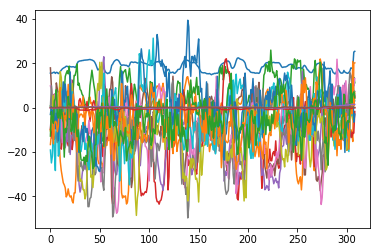

In [8]:
train_data = load_train_data('mfcc')

print(train_data['0002f1cd968ca78ada9e1c7037224773']['features'].shape)

length = []
for key in train_data.keys():
    length.append(train_data[key]['features'].shape)
length = np.array(length)

print(length.mean())
print(length.max())
print(length.min())

plt.plot(train_data['0002f1cd968ca78ada9e1c7037224773']['features'])

In [ ]:
x = np.load('corevo/features/spectrogram/x_train.npy')
f_names, y = np.load('corevo/features/spectrogram/test.pkl')

# format data

In [5]:
def imshow_sox(spectrogram, rm_low = 0.1):
    max_value = np.max(spectrogram)

    ### amp to dbFS
    db_spec = np.log10(spectrogram / float(max_value)) * 20
    db_spec = db_spec.astype(np.int16)


    ### カラーマップの上限と下限を計算
    hist, bin_edges = scipy.histogram(db_spec.flatten(), bins = 1000, normed = True)
    hist /= float(hist.sum())
    S = 0
    ii = 0
    while S < rm_low:
        S += hist[ii]
        ii += 1
    vmin = bin_edges[ii]
    vmax = np.max(db_spec)
    
    spec_num=np.shape(db_spec)[0]
    print(np.shape(db_spec))
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    fig = plt.figure(figsize=(20,20))
    for i in range(spec_num):
        ax=plt.subplot(4,2,i+1)
        #ax.subplots_adjust(wspace=0.01, hspace=0.01)
        ax.tick_params(labelbottom="off",bottom="off") # x軸の削除
        ax.tick_params(labelleft="off",left="off") # y軸の削除
        ax.set_xticklabels([]) 
        ax.set_title("({})".format(i+1))
#         import pdb;pdb.set_trace()
        ax.imshow(db_spec[i,:], origin = "lower", aspect = "auto", cmap = "hot", vmax = vmax, vmin = vmin)
    plt.subplots_adjust(hspace=0.1)
    plt.show()


(1025, 101)
(1, 384, 101)


/home/aaa10286uy/miniconda3/envs/gpu/lib/python3.6/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # Remove the CWD from sys.path while we load stuff.
/home/aaa10286uy/miniconda3/envs/gpu/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

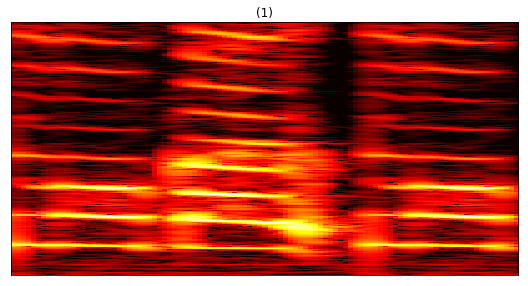

(384, 101) (384,) (101,)


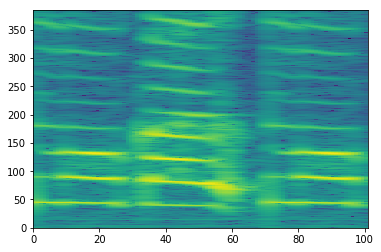

-114 0


In [6]:
# fs, data = load_wav('0316ae7c2fb957366804b171d64a944a')
fs, data = wavfile.read(f'corevo/raw/test/0316ae7c2fb957366804b171d64a944a.wav')

data = np.tile(data, 2)

data = data[:n_input]
# f,t,Sxx = signal.spectrogram(data, fs, nperseg=n_window, noverlap=n_overlap)
f,t,Sxx = stft(data, fs, nperseg=n_window, noverlap=n_overlap)
print(Sxx.shape)

Sxx = abs(Sxx)

f_cut = np.argwhere(f==3000.0)[0,0]
f = f[:f_cut]
Sxx = Sxx[:f_cut, :]

imshow_sox(np.expand_dims(Sxx,axis=0))

Sxx= np.log10(Sxx / np.max(Sxx)) * 20

print(Sxx.shape, f.shape, t.shape)
Sxx = Sxx.astype(np.int16)

plt.figure()
plt.pcolormesh(Sxx, vmax=None)
plt.show()

print(Sxx.min(), Sxx.max())

# plt.ylim(0, 2000)
# plt.xlim([0,18])
# plt.xlabel(u"時間 [sec]")
# plt.ylabel(u"周波数 [Hz]")
# plt.colorbar()


# format training data

In [7]:
train_set = np.loadtxt('corevo/raw/class_train.tsv', dtype=str)
N = len(train_set)
perm = np.random.permutation(N)
n_split = int(N*0.95)

f_train = train_set[perm[:n_split]]
f_val = train_set[perm[n_split:]]

label_dict = {'MA_CH':0, 'MA_AD':1, 'MA_EL':2,'FE_CH':3, 'FE_AD':4, 'FE_EL':5}

In [ ]:
datas = []
labels = []


for f_name, label in tqdm_notebook(f_train):
    fs, data = load_wav(f_name)
    n_data = len(data)
    
    if n_data < n_input:
        data = np.tile(data, 2)
#         n_data = len(data)

    # ウィンドウをずらしながらデータに追加
    for n_start in range(0, n_data-n_input, n_input_stride):
        data_crop = data[n_start:n_start+n_input]
        plt.plot(data_crop)
        exit()
        
        # FFT
        f,t,spectrogram = stft(data_crop, fs, nperseg=n_window, noverlap=n_overlap)
        spectrogram = abs(spectrogram)
        
        # 低音領域のみ抽出
        f_cut = np.argwhere(f==3000.0)[0,0]
        f = f[:f_cut]
        spectrogram = spectrogram[:f_cut, :]
        
        # dB変換
        try:
            db_spec= np.log10(spectrogram / np.max(spectrogram)) * 20
        except RuntimeWarning:
            continue
        db_spec = db_spec.astype(np.int16)
        
#         plt.pcolormesh(db_spec, vmax=None)
#         plt.show()
        
        datas.append(db_spec)
        labels.append(label)

# save training data
datas = np.array(datas)
# x_max = datas.max()
# x_train_norm = datas

# np.save('corevo/features/spectrogram/x_train.npy', datas)
# np.save('corevo/features/spectrogram/x_train_max.npy', x_max)


labels_int = np.array([label_dict[l] for l in labels])

# np.save('corevo/features/spectrogram/y_train.npy', labels_int)

### Old

In [ ]:
# format validation data
all_datas = []

for f_name, label in tqdm_notebook(f_val):
    fs, data = load_wav(f_name)
    n_data = len(data)
    
    while n_data < n_input:
        data = np.tile(data, 2)
        n_data = len(data)

    # ウィンドウをずらしながらデータに追加
    case_data = []
    for n_start in range(0, n_data-n_input, n_input_stride):
        data_crop = data[n_start:n_start+n_input]
        f,t,spectrogram = stft(data_crop, fs, nperseg=n_window, noverlap=n_overlap)
        spectrogram = abs(spectrogram)
        
        f_cut = np.argwhere(f==3000.0)[0,0]
        f = f[:f_cut]
        spectrogram = spectrogram[:f_cut, :]
        
        try:
            db_spec= np.log10(spectrogram / np.max(spectrogram)) * 20
        except RuntimeWarning:
            continue
        db_spec = db_spec.astype(np.int16)

        case_data.append(db_spec)
    labels_int = label_dict[label]
    all_datas.append([case_data, labels_int])
    
# save validation data
with open('corevo/features/spectrogram/validation.pkl', mode='wb') as f:
    pickle.dump(all_datas, f)

In [ ]:
# format test data
f_names = !ls corevo/raw/test/ | grep wav

x_max = np.load('corevo/features/spectrogram/x_train_max.npy')
all_datas = []

for f_name in tqdm_notebook(f_names):
    fs, data = wavfile.read(f'corevo/raw/test/{f_name}')
    n_data = len(data)
    
    if n_data < n_input:
        data = np.tile(data, 2)

    # ウィンドウをずらしながらデータに追加
    case_data = []
    for n_start in range(0, n_data-n_input, n_input_stride):
        data_crop = data[n_start:n_start+n_input]
        f,t,spectrogram = stft(data_crop, fs, nperseg=n_window, noverlap=n_overlap)
        spectrogram = abs(spectrogram)
        
        f_cut = np.argwhere(f==3000.0)[0,0]
        f = f[:f_cut]
        spectrogram = spectrogram[:f_cut, :]
        
        try:
            db_spec= np.log10(spectrogram / np.max(spectrogram)) * 20
        except RuntimeWarning:
            continue
        db_spec = db_spec.astype(np.int16)

        case_data.append(db_spec)
    all_datas.append(case_data)
    
with open('corevo/features/spectrogram/test.pkl', mode='wb') as f:
    pickle.dump([f_names, all_datas], f)
    


In [10]:
len(all_datas), len(all_datas[0]), all_datas[0][0].shape, all_datas[0][0].dtype

(17888, 4, (128, 94), dtype('float32'))